### importing and parsing

In [907]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score as evs
from sklearn.metrics import r2_score as r2
from sklearn.preprocessing import LabelEncoder
from scipy.stats import norm
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, mean_squared_error

In [715]:
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M')

df_york = pd.read_csv("df_york_model.csv", parse_dates=['post_timing'], date_parser=dateparse, index_col = 0)
df_philly = pd.read_csv("df_philly_model.csv", parse_dates=['post_timing'], date_parser=dateparse, index_col = 0)

In [716]:
df_york['post_timing'].max()

Timestamp('2021-02-18 16:47:00')

In [717]:
df_philly['post_timing'].max()

Timestamp('2021-02-18 17:22:00')

In [718]:
df_york['post_timing_days'] = (df_york['post_timing'].max() - df_york['post_timing']).dt.days
df_york = df_york.drop(columns = ['post_timing'])
df_philly['post_timing_days'] = (df_philly['post_timing'].max() - df_philly['post_timing']).dt.days
df_philly = df_philly.drop(columns = ['post_timing'])

<AxesSubplot:>

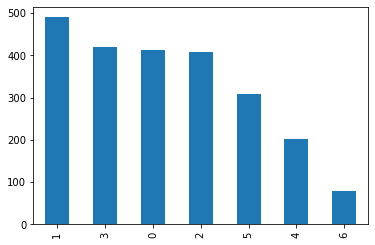

In [719]:
(df_york['post_timing_days'].astype(str)).value_counts(ascending = False)[:15].plot(kind='bar')

<AxesSubplot:xlabel='post_timing_days'>

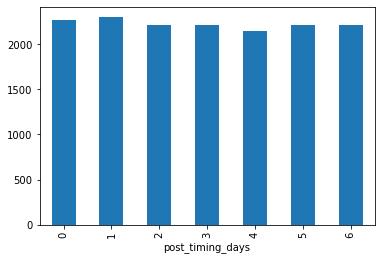

In [720]:
#The average for different housing types for number of days old in Craiglist looks same.
df_york.groupby(['post_timing_days'])['post_prices'].mean().plot(kind = 'bar')

<AxesSubplot:xlabel='post_timing_days'>

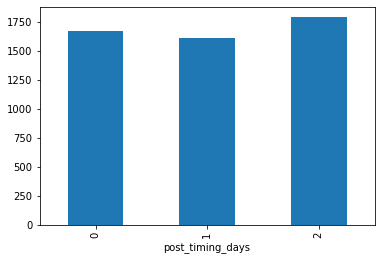

In [721]:
df_philly.groupby(['post_timing_days'])['post_prices'].mean().plot(kind = 'bar')

In [722]:
#Compare to Newyork , Philly has listing post just 2 days old.

### Change float to integer
There are number of features like sqfts, price , bedroom and bathroom count in float

In [723]:
df_york.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2321 entries, 0 to 2321
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   post_prices       2321 non-null   float64
 1   sqfts             2321 non-null   float64
 2   bedroom_counts    2321 non-null   float64
 3   No_of_bathrooms   2321 non-null   float64
 4   pet               2321 non-null   object 
 5   laundry           2321 non-null   object 
 6   parking           2321 non-null   object 
 7   Apartment_type    2321 non-null   object 
 8   postcode          2321 non-null   object 
 9   pickup cluster    2321 non-null   int64  
 10  post_timing_days  2321 non-null   int64  
dtypes: float64(4), int64(2), object(5)
memory usage: 217.6+ KB


In [724]:
columns = df_york.select_dtypes(include=['float']).columns

In [725]:
def change_float(df):
    '''Change the float columns into integer in pandas DataFrame'''
    for col in df.select_dtypes(include=['float']).columns:
        df[col]= df[col].astype(int)
    return df
change_float(df_york)
change_float(df_philly)

,post_prices,sqfts,bedroom_counts,No_of_bathrooms,pet,laundry,parking,Apartment_type,postcode,pickup cluster,post_timing_days
0,3045,1002,2,2,both pets,in unit,no,multi,19123,7,0
1,1000,859,1,1,no pet,in unit,off-street,multi,19148,3,0
2,2487,859,1,1,no pet,in unit,no,multi,19104,12,0
3,1690,1100,1,1,no pet,in unit,no,multi,19106,3,0
4,1100,859,1,1,both pets,no laundry,no,multi,19130,17,0
...,...,...,...,...,...,...,...,...,...,...,...
1809,1000,859,1,1,both pets,on site,no,multi,19125,7,2
1810,1300,859,1,1,both pets,in unit,no,multi,19147,3,2
1811,2177,780,1,1,both pets,in unit,proctected,multi,19107,17,2
1812,5895,1610,5,2,both pets,in unit,no,multi,19104,12,2


In [726]:
df_york.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2321 entries, 0 to 2321
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   post_prices       2321 non-null   int64 
 1   sqfts             2321 non-null   int64 
 2   bedroom_counts    2321 non-null   int64 
 3   No_of_bathrooms   2321 non-null   int64 
 4   pet               2321 non-null   object
 5   laundry           2321 non-null   object
 6   parking           2321 non-null   object
 7   Apartment_type    2321 non-null   object
 8   postcode          2321 non-null   object
 9   pickup cluster    2321 non-null   int64 
 10  post_timing_days  2321 non-null   int64 
dtypes: int64(6), object(5)
memory usage: 217.6+ KB


In [727]:
df_philly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1808 entries, 0 to 1813
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   post_prices       1808 non-null   int64 
 1   sqfts             1808 non-null   int64 
 2   bedroom_counts    1808 non-null   int64 
 3   No_of_bathrooms   1808 non-null   int64 
 4   pet               1808 non-null   object
 5   laundry           1808 non-null   object
 6   parking           1808 non-null   object
 7   Apartment_type    1808 non-null   object
 8   postcode          1808 non-null   object
 9   pickup cluster    1808 non-null   int64 
 10  post_timing_days  1808 non-null   int64 
dtypes: int64(6), object(5)
memory usage: 169.5+ KB


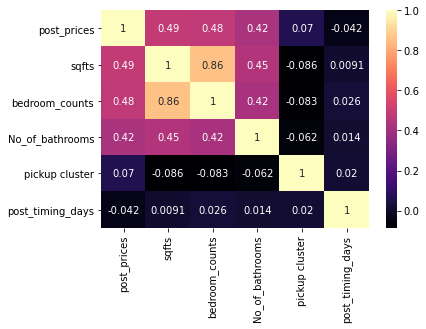

In [728]:
sns.heatmap(df_york.corr(), annot = True, cmap = 'magma')

plt.savefig('york_heatmap.png')
plt.show()

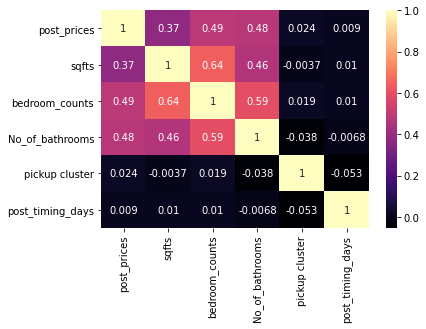

In [729]:
sns.heatmap(df_philly.corr(), annot = True, cmap = 'magma')

plt.savefig('philly_heatmap.png')
plt.show()

Post_timing_days is not correlated with post_prices or any other features.
Bedroom Count is correlated with sqfts and post prices and bathroom counts.

#### Stack vertically both philadelphia and York to train the model

In [816]:
df = pd.concat([df_york, df_philly])

In [817]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4129 entries, 0 to 1813
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   post_prices       4129 non-null   int64 
 1   sqfts             4129 non-null   int64 
 2   bedroom_counts    4129 non-null   int64 
 3   No_of_bathrooms   4129 non-null   int64 
 4   pet               4129 non-null   object
 5   laundry           4129 non-null   object
 6   parking           4129 non-null   object
 7   Apartment_type    4129 non-null   object
 8   postcode          4129 non-null   object
 9   pickup cluster    4129 non-null   int64 
 10  post_timing_days  4129 non-null   int64 
dtypes: int64(6), object(5)
memory usage: 387.1+ KB


/opt/anaconda3/envs/Geo_pandas37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


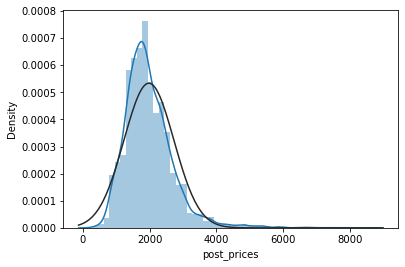

In [818]:
sns.distplot(df['post_prices'], fit = norm)
(mu, sigma) = norm.fit(df['post_prices'])

In [819]:
def ecdf(df):
    """Compute ECDF for a one-dimensional array of measurements."""
    n = len(df)

    x = np.sort(df)

    y = np.arange(1, n+1) / n

    return x, y

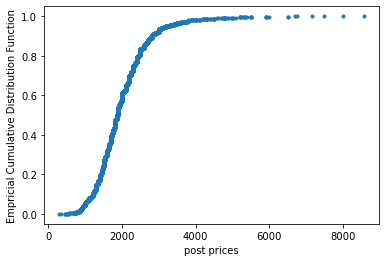

In [820]:
x_vers, y_vers = ecdf(df['post_prices'])

# Generate plot
plt.plot(x_vers, y_vers, marker = '.', linestyle = 'none')

# Label the axes
plt.xlabel('post prices')
plt.ylabel('Empricial Cumulative Distribution Function')


# Display the plot
plt.show()

We have 70% data having listing price less than $2800

### Label Encoding

In [821]:
non_num = df.select_dtypes(include=['object']).columns
for c in non_num:
    lbl = LabelEncoder() 
    lbl.fit(list(df[c].values)) 
    df[c] = lbl.transform(list(df[c].values))

### Linear_Regression_Model

In [876]:
X_df = df[['sqfts', 'bedroom_counts', 'No_of_bathrooms', 'pickup cluster', 'post_timing_days','pet', 'laundry', 'parking', 'Apartment_type', 'postcode']]

In [877]:
y_df= df[['post_prices']]

In [878]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size = 0.3, random_state = 42)

In [879]:
len(np.array(y_test))

1239

In [880]:
len(np.array(ols_pred))

826

In [881]:
 from sklearn.metrics import f1_score

In [882]:
ols = LinearRegression()
ols.fit(X_train, y_train)
ols_pred = ols.predict(X_test)

In [883]:
#mean square error
np.sqrt(mean_squared_error(y_test, ols_pred))

577.4690316240085

In [884]:
#explained_variance_score
evs(y_test, ols_pred)

0.4213458690902161

In [885]:
#r-squared error
r2(y_test, ols_pred)

0.421340163443067

### Bayesian_model

In [886]:
bayesian = BayesianRidge()
bayesian.fit(X_train, y_train)
bayesian_pred = bayesian.predict(X_test)

/opt/anaconda3/envs/Geo_pandas37/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [887]:
#explained_variance_score
evs(y_test, bayesian_pred)

0.42089208577492954

In [888]:
r2(y_test, bayesian_pred)

0.4208862730962466

In [889]:
#mean square error
np.sqrt(mean_squared_error(y_test, bayesian_pred))

577.6954653805191

### XGB_regressor

In [890]:
xgb_m = xgb.XGBRegressor(objective ='reg:linear', 
                  n_estimators = 10, seed = 123)

In [891]:
xgb_m.fit(X_train, y_train) 
xgb_pred = xgb_m.predict(X_test)

[21:14:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


In [892]:
evs(y_test, xgb_pred)

0.5813196117552162

In [893]:
r2(y_test, xgb_pred)

0.5733427042456434

In [894]:
np.sqrt(mean_squared_error(y_test, xgb_pred))

495.85719247939596

### RandomForest_Regressor

In [896]:
rf_reg = RandomForestRegressor(random_state = 42)

In [897]:
rf_reg.fit(X_train, y_train) 
rf_pred = rf_reg.predict(X_test)

/opt/anaconda3/envs/Geo_pandas37/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


In [898]:
print(rf_reg.score(X_test,y_test))
print(r2(y_test,rf_pred))


0.5909979564957477
0.5909979564957477


In [899]:
np.sqrt(mean_squared_error(y_test, rf_pred))

485.489417609241

In [900]:
evs(y_test, rf_pred)

0.5911343118210919

### Use K folds Cross Validation

#### cross val with xgboostregressor

In [901]:
cv_r2_scores_xgb = cross_val_score(xgb_m, X_df, y_df, cv=5,scoring='r2')

[21:15:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


In [902]:
print(cv_r2_scores_xgb)
print(np.mean(cv_r2_scores_xgb))

[0.3418751  0.43356648 0.51929662 0.47324876 0.56137795]
0.465872983660155


#### cross val with randomforestregressor

In [903]:
cv_r2_scores_rf = cross_val_score(rf_reg, X_df, y_df, cv=5,scoring='r2')

/opt/anaconda3/envs/Geo_pandas37/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/Geo_pandas37/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/Geo_pandas37/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/Geo_pandas37/lib/python3.7/site-packages/sklearn/model_s

In [904]:
print(cv_r2_scores_rf)
print(cv_r2_scores_rf.mean())

[0.3441667  0.3548682  0.5248401  0.50287505 0.63328871]
0.4720077525560315


### Manually perform the training repeatedly on each k-1 folds (x_train, y_train) and 
use the Kth fold (x_test, y_test) for testing 

#### RandomForestRegressor

In [905]:
scores = []
for i in range(5):
    result = next(kf.split(X_df), None)
    X_train = X_df.iloc[result[0]]
    X_test = X_df.iloc[result[1]]
    y_train = y_df.iloc[result[0]]
    y_test = y_df.iloc[result[1]]
    rf_reg.fit(X_train,y_train)
    predictions = rf_reg.predict(X_test)
    scores.append(r2(y_test, predictions))
print('Scores from each Iteration: ', scores)
print('Average K-Fold Score :' , np.mean(scores))

/opt/anaconda3/envs/Geo_pandas37/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/opt/anaconda3/envs/Geo_pandas37/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/opt/anaconda3/envs/Geo_pandas37/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/opt/anaconda3/envs/Geo_pandas37/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/opt/anaconda3/envs/Geo_

Scores from each Iteration:  [0.6128487730176415, 0.5888013832750008, 0.6019223286071079, 0.5698204078910376, 0.6431469081786318]
Average K-Fold Score : 0.6033079601938839


In [906]:
np.sqrt(mean_squared_error(y_test, predictions))

449.83866469608597

#### XGBooostRegressor

In [847]:
scores = []
for i in range(5):
    result = next(kf.split(X_df), None)
    X_train = X_df.iloc[result[0]]
    X_test = X_df.iloc[result[1]]
    y_train = y_df.iloc[result[0]]
    y_test = y_df.iloc[result[1]]
    model = xgb_m.fit(X_train,y_train)
    predictions = xgb_m.predict(X_test)
    scores.append(model.score(X_test,y_test))
print('Scores from each performance: ', scores)
print('Average score :' , np.mean(scores))

[20:52:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[20:52:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[20:52:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[20:52:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[20:52:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
Scores from each performance:  [0.4819935634222045, 0.5593881854335354, 0.6044320367450925, 0.5256576155256145

# HyperParameter Tuning Using GridSearch

In [848]:
def Grid_Search_CV_RFR(X_train, y_train):

    estimator = RandomForestRegressor(random_state = 42)
    param_grid = { 
            "n_estimators"      : [5,10,20,30,40],
            "max_features"      : ["auto", "sqrt", "log2"],
            "min_samples_split" : [2,4,6,8,10],
            "bootstrap": [True, False],
            }

    grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=5, verbose = 2)

    grid.fit(X_df, y_df)

    return grid.best_score_ , grid.best_params_

In [849]:
Grid_Search_CV_RFR(X_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:   21.1s finished
/opt/anaconda3/envs/Geo_pandas37/lib/python3.7/site-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


(0.48820245477169505,
 {'bootstrap': True,
  'max_features': 'sqrt',
  'min_samples_split': 4,
  'n_estimators': 40})

In [621]:
#Using the best params from the GridSearch
rf_reg = RandomForestRegressor(bootstrap= True, max_features= 'sqrt', min_samples_split= 4, n_estimators=40, random_state =42)

In [622]:
cv_r2_scores_rf = cross_val_score(rf_reg, X_df, y_df, cv=5, scoring='r2')

In [623]:
print(cv_r2_scores_rf)
print(cv_r2_scores_rf.mean())

[0.39252631 0.43068981 0.51617969 0.50949058 0.59212588]
0.48820245477169505


#### Our data is limited for the better prediction. On comparing the different model, RandomForestClassifer shows better performance.